<a href="https://colab.research.google.com/github/LauraPrieto0124/Colombia_EKC_estimation/blob/main/NTL_col_validation_ADM2_new_geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Import necesary packages and libraries
import pandas as pd
import geopandas as gpd
from shapely import wkt
import json
from shapely.geometry import shape
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pip install --upgrade geopandas matplotlib

In [3]:
!pip install mapclassify>=2.4.0
!pip install contextily
import contextily as cx

In [4]:
!pip install plotly
import plotly.express as px # import the plotly.express module and alias it as px


In [5]:
!pip install linearmodels
import linearmodels
from linearmodels import PooledOLS  # Function to perform pooled OLS regression
from linearmodels import PanelOLS  # Function to perform OLS regression on panel data
from linearmodels import (
    BetweenOLS,
)  # Function to compute the between estimator of an OLS regression
from linearmodels.panel.results import (
    compare,
)  # Function compare results of an OLS regression


In [6]:
#@title Import and procesing NTL data
gdf = gpd.read_file("https://raw.githubusercontent.com/LauraPrieto0124/Colombia_EKC_estimation/main/Data/sum_NTL_adm2_col.geojson")

In [7]:
gdf = gdf.rename(columns = {"sum": "sumNTL"})
gdf.head(3)

,id,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,ADM2_CODE,ADM2_NAME,DISP_AREA,EXP2_YEAR,STATUS,STR2_YEAR,Shape_Area,Shape_Leng,sumNTL,year,geometry
0,20160101_00020000000000001bf9,57,Colombia,934,Amazonas,13333,El Encanto,NO,3000,Member State,1000,0.880307,7.970986,0.0,2016,"POLYGON ((-74.39066 -0.59288, -74.38841 -0.601..."
1,20160101_00020000000000001bfa,57,Colombia,934,Amazonas,13334,La Chorrera,NO,3000,Member State,1000,1.806759,7.253629,0.0,2016,"POLYGON ((-72.62549 -2.42766, -72.62325 -2.423..."
2,20160101_00020000000000001bfb,57,Colombia,934,Amazonas,13335,La Pedrera,NO,3000,Member State,1000,1.961139,9.741906,0.0,2016,"MULTIPOLYGON (((-69.42529 -1.06898, -69.42305 ..."


In [ ]:
gdf.describe()

,ADM0_CODE,ADM1_CODE,ADM2_CODE,EXP2_YEAR,STR2_YEAR,Shape_Area,Shape_Leng,sumNTL,year
count,6516.0,6516.000000,6516.000000,6516.0,6516.0,6516.000000,6516.000000,6516.000000,6516.000000
mean,57.0,948.447514,13876.081952,3000.0,1000.0,0.085457,1.133588,737.455931,2018.500000
std,0.0,9.633427,313.946639,0.0,0.0,0.250491,1.359958,3449.176531,1.707956
min,57.0,934.000000,13333.000000,3000.0,1000.0,0.000056,0.030417,-3.328588,2016.000000
25%,57.0,939.000000,13604.000000,3000.0,1000.0,0.010638,0.473865,31.408193,2017.000000
50%,57.0,948.000000,13876.500000,3000.0,1000.0,0.023071,0.731488,104.412856,2018.500000
75%,57.0,956.000000,14148.000000,3000.0,1000.0,0.056684,1.212882,397.851223,2020.000000
max,57.0,966.000000,14419.000000,3000.0,1000.0,4.035887,14.930363,89833.579558,2021.000000


In [ ]:
negative_values = gdf[gdf["sumNTL"] < 0]
print(negative_values)

                                 id  ADM0_CODE ADM0_NAME  ADM1_CODE ADM1_NAME  \
5434  20210101_00020000000000001bfd         57  Colombia        934  Amazonas   
5436  20210101_00020000000000001bff         57  Colombia        934  Amazonas   
6191  20210101_00020000000000001ef2         57  Colombia        955    Narino   

      ADM2_CODE         ADM2_NAME DISP_AREA  EXP2_YEAR        STATUS  \
5434      13337     Miriti Parana        NO       3000  Member State   
5436      13339  Puerto Santander        NO       3000  Member State   
6191      14096             Magui        NO       3000  Member State   

      STR2_YEAR  Shape_Area  Shape_Leng    sumNTL  year  \
5434       1000    1.345336    7.145437 -2.904622  2021   
5436       1000    0.734671    5.408347 -0.760922  2021   
6191       1000    0.291128    2.350163 -3.328588  2021   

                                               geometry  
5434  POLYGON ((-71.36563 -0.59063, -71.38584 -0.651...  
5436  POLYGON ((-72.56711 -0.7141

In [ ]:
gdf = gdf[gdf["sumNTL"] > 0]

In [ ]:
gdf['ADM2_NAME'] = gdf['ADM2_NAME'].str.replace('¥', 'n')

In [ ]:
gdf['ADM1_NAME'] = gdf['ADM1_NAME'].replace('Narino', 'Nariño')

In [ ]:
LOG_OFFSET_1 = 0.01
scaling_factor = 1000
gdf["ln_sumNTL"] = np.log(scaling_factor*(LOG_OFFSET_1 + gdf["sumNTL"]))

In [ ]:
gdf_clean = gdf[["ADM1_NAME", "ADM2_NAME", "sumNTL", "ln_sumNTL", "year", "geometry"]]

In [ ]:
gdf_clean.columns = gdf_clean.columns.astype(str)

In [8]:
# @title Import and processing total value added information
df = pd.read_csv("https://raw.githubusercontent.com/LauraPrieto0124/Colombia_EKC_estimation/main/Data/value_added_ADM2_Col.csv", sep =";")
df.head(3)

,Municipio,Departamento,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Medellin,Antioquia,34442.533360,36924.720130,40880.873860,43042.337120,45551.404610,49047.761440,51394.011710,55082.301180,59434.966210,57154.227670,66893.738730,76890.363960
1,Abejorral,Antioquia,127.175011,149.297199,148.804371,159.844908,172.950168,202.311691,234.833122,231.172055,244.497253,242.227453,335.473279,450.557947
2,Abriaqui,Antioquia,17.549168,17.277452,17.646686,18.790072,18.197030,20.171697,21.674609,28.562662,31.817283,32.922291,38.193009,58.306037


In [ ]:
df = df.rename(columns = {"Municipio ": "ADM2_NAME"})
df = df.rename(columns = {"Departamento": "ADM1_NAME"})
df.head(3)

,ADM2_NAME,ADM1_NAME,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Medellin,Antioquia,34442.533360,36924.720130,40880.873860,43042.337120,45551.404610,49047.761440,51394.011710,55082.301180,59434.966210,57154.227670,66893.738730,76890.363960
1,Abejorral,Antioquia,127.175011,149.297199,148.804371,159.844908,172.950168,202.311691,234.833122,231.172055,244.497253,242.227453,335.473279,450.557947
2,Abriaqui,Antioquia,17.549168,17.277452,17.646686,18.790072,18.197030,20.171697,21.674609,28.562662,31.817283,32.922291,38.193009,58.306037


In [ ]:
df.columns = df.columns.astype(str)

In [ ]:
df = pd.melt(
    df,
    id_vars=["ADM2_NAME", "ADM1_NAME"],
    value_vars= ["2016", "2017", "2018", "2019", "2020", "2021"],
    var_name="year",
    value_name="GDP")
df.head()

,ADM2_NAME,ADM1_NAME,year,GDP
0,Medellin,Antioquia,2016,49047.761440
1,Abejorral,Antioquia,2016,202.311691
2,Abriaqui,Antioquia,2016,20.171697
3,Alejandria,Antioquia,2016,46.560466
4,Amaga,Antioquia,2016,358.089541


In [ ]:
df["year"] = df["year"].astype(int)

In [ ]:
gdf_merged = pd.merge(gdf_clean, df, on=["ADM1_NAME","ADM2_NAME", "year"], how="inner")
gdf_merged.head()

,ADM1_NAME,ADM2_NAME,sumNTL,ln_sumNTL,year,geometry,GDP
0,Amazonas,Leticia,407.028357,12.916663,2016,"POLYGON ((-70.13944 -3.26308, -70.15516 -3.283...",469.186170
1,Amazonas,Tarapaca,0.143182,5.031627,2016,"POLYGON ((-71.79906 -2.1941, -71.79456 -2.1941...",15.168626
2,Antioquia,Abejorral,192.184141,12.166261,2016,"POLYGON ((-75.32265 5.79854, -75.30917 5.80303...",202.311691
3,Antioquia,Abriaqui,12.914525,9.466882,2016,"POLYGON ((-76.07722 6.52841, -76.07273 6.51943...",20.171697
4,Antioquia,Alejandria,35.364022,10.473733,2016,"POLYGON ((-75.19239 6.29261, -75.19464 6.28812...",46.560466


In [ ]:
ADM2_amount = gdf_merged["ADM2_NAME"].nunique()
print(ADM2_amount)

911


In [ ]:
def string_to_float(s):
    # Check if the value is already a float or a numeric type
    if isinstance(s, (float, int)):
        return s
    # If not numeric, then proceed with string conversion
    s = s.strip()  # Elimina espacios al inicio y al final
    if s == '-':
        return 0.0  # O puedes devolver None si prefieres
    try:
        return float(s)
    except ValueError:
        return None  # O puedes manejar el error de otra manera

gdf_merged["GDP"] = gdf_merged["GDP"].apply(string_to_float)

In [ ]:
# @title CODE: Add offset to compute log values

LOG_OFFSET = 0.01
gdf_merged["lnGDP"] = np.log(LOG_OFFSET + gdf_merged["GDP"])
gdf_merged.head()

,ADM1_NAME,ADM2_NAME,sumNTL,ln_sumNTL,year,geometry,GDP,lnGDP
0,Amazonas,Leticia,407.028357,12.916663,2016,"POLYGON ((-70.13944 -3.26308, -70.15516 -3.283...",469.186170,6.151021
1,Amazonas,Tarapaca,0.143182,5.031627,2016,"POLYGON ((-71.79906 -2.1941, -71.79456 -2.1941...",15.168626,2.719888
2,Antioquia,Abejorral,192.184141,12.166261,2016,"POLYGON ((-75.32265 5.79854, -75.30917 5.80303...",202.311691,5.309859
3,Antioquia,Abriaqui,12.914525,9.466882,2016,"POLYGON ((-76.07722 6.52841, -76.07273 6.51943...",20.171697,3.004776
4,Antioquia,Alejandria,35.364022,10.473733,2016,"POLYGON ((-75.19239 6.29261, -75.19464 6.28812...",46.560466,3.840967


In [ ]:
START_YEAR = 2016
END_YEAR = 2021

In [ ]:
# @title Create the maps
# Pivotear sin incluir la columna de geometría
gdf_pivoted = gdf.pivot(index=["ADM2_CODE", "ADM2_NAME"], columns='year', values='ln_sumNTL')

# Restablecer el índice y mantener la geometría
gdf_pivoted = gdf_pivoted.reset_index()
gdf_pivoted = gdf_pivoted.merge(gdf[["ADM2_CODE", "geometry"]], on="ADM2_CODE", how="left")

# Convertir de nuevo a GeoDataFrame
gdf_pivoted = gpd.GeoDataFrame(gdf_pivoted, geometry="geometry")


# Mostrar el resultado
gdf_pivoted.head()

,ADM2_CODE,ADM2_NAME,2016,2017,2018,2019,2020,2021,geometry
0,13335,La Pedrera,NaN,6.982419,7.837215,7.072914,NaN,7.867603,"MULTIPOLYGON (((-69.42305 -1.07347, -69.41856 ..."
1,13335,La Pedrera,NaN,6.982419,7.837215,7.072914,NaN,7.867603,"MULTIPOLYGON (((-69.42305 -1.07347, -69.41856 ..."
2,13335,La Pedrera,NaN,6.982419,7.837215,7.072914,NaN,7.867603,"MULTIPOLYGON (((-69.42305 -1.07347, -69.41856 ..."
3,13335,La Pedrera,NaN,6.982419,7.837215,7.072914,NaN,7.867603,"MULTIPOLYGON (((-69.42305 -1.07347, -69.41856 ..."
4,13336,Leticia,12.916663,12.982814,13.030640,12.943588,13.071813,13.130778,"POLYGON ((-70.13944 -3.26308, -70.15516 -3.283..."


In [ ]:
gdf_pivoted.columns = gdf_pivoted.columns.astype(str)

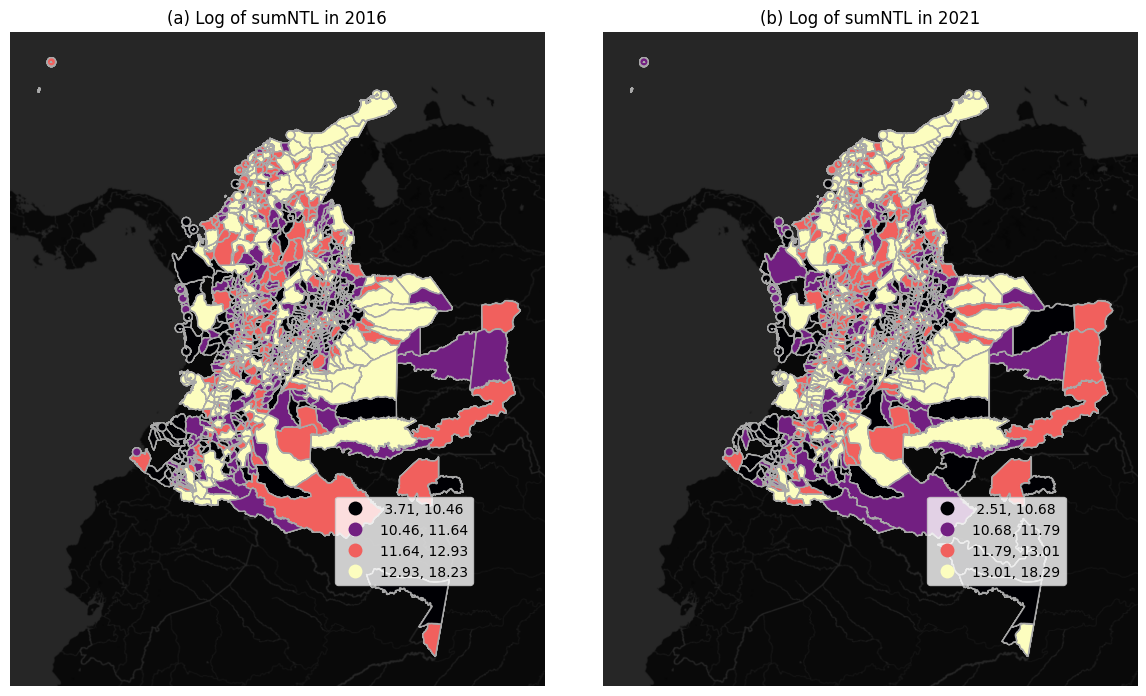

In [ ]:
# @title Plot static map of (log) sumNTL for the initial and final year

# A figure is initialized
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

# The plot of the start year is added
gdf_pivoted.plot(
    column=str(START_YEAR),
    scheme="user_defined",
    classification_kwds={"bins": [10.46, 11.64, 12.93]},
    k=4,
    cmap="magma",
    edgecolor="darkgrey",
    legend=True,
    ax=axes[0],
    legend_kwds={"bbox_to_anchor": (0.88, 0.30)},
)
cx.add_basemap(
    ax=axes[0],
    crs=gdf_pivoted.crs.to_string(),
    source=cx.providers.CartoDB.DarkMatterNoLabels,
    attribution=False,
)


# The plot of the end year is added.
gdf_pivoted.plot(
    column=str(END_YEAR),
    scheme="Quantiles",
    k=4,
    cmap="magma",
    edgecolor="darkgrey",
    legend=True,
    ax=axes[1],
    legend_kwds={"bbox_to_anchor": (0.88, 0.30)},
)
cx.add_basemap(
    ax=axes[1],
    crs=gdf_pivoted.crs.to_string(),
    source=cx.providers.CartoDB.DarkMatterNoLabels,
    attribution=False,
)

plt.tight_layout()
axes[0].axis("off")
axes[1].axis("off")
axes[0].set_title("(a) Log of sumNTL in " + str(START_YEAR))
axes[1].set_title("(b) Log of sumNTL in " + str(END_YEAR))

plt.savefig("ln_sumNTL.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
gdf_lnGDP = gdf_merged[["ADM2_NAME", "ADM1_NAME", "year", "lnGDP", "geometry"]]
gdf_lnGDP.head()

,ADM2_NAME,ADM1_NAME,year,lnGDP,geometry
0,Leticia,Amazonas,2016,6.151021,"POLYGON ((-70.13944 -3.26308, -70.15516 -3.283..."
1,Tarapaca,Amazonas,2016,2.719888,"POLYGON ((-71.79906 -2.1941, -71.79456 -2.1941..."
2,Abejorral,Antioquia,2016,5.309859,"POLYGON ((-75.32265 5.79854, -75.30917 5.80303..."
3,Abriaqui,Antioquia,2016,3.004776,"POLYGON ((-76.07722 6.52841, -76.07273 6.51943..."
4,Alejandria,Antioquia,2016,3.840967,"POLYGON ((-75.19239 6.29261, -75.19464 6.28812..."


In [ ]:
# Pivotear sin incluir la columna de geometría
gdf_pivoted_lnGDP = gdf_lnGDP.pivot(index=["ADM1_NAME","ADM2_NAME", "geometry"], columns='year', values='lnGDP')

# Restablecer el índice y mantener la geometría
gdf_pivoted_lnGDP = gdf_pivoted_lnGDP.reset_index()

gdf_pivoted_lnGDP.head(10)

year,ADM1_NAME,ADM2_NAME,geometry,2016,2017,2018,2019,2020,2021
0,Amazonas,La Pedrera,"MULTIPOLYGON (((-69.42305 -1.07347, -69.41856 ...",NaN,2.757521,2.840308,2.906542,NaN,2.880533
1,Amazonas,Leticia,"POLYGON ((-70.13944 -3.26308, -70.15516 -3.283...",6.151021,6.274586,6.296769,6.355688,6.311147,6.508308
2,Amazonas,Puerto Narino,"POLYGON ((-70.66944 -3.80431, -70.6627 -3.8088...",NaN,NaN,4.576164,4.647418,4.675559,4.667473
3,Amazonas,Tarapaca,"POLYGON ((-71.79906 -2.1941, -71.79456 -2.1941...",2.719888,2.648225,2.726843,2.851271,2.784790,2.902123
4,Antioquia,Abejorral,"POLYGON ((-75.32265 5.79854, -75.30917 5.80303...",5.309859,5.458918,5.443206,5.499245,5.489918,5.815572
5,Antioquia,Abriaqui,"POLYGON ((-76.07722 6.52841, -76.07273 6.51943...",3.004776,3.076603,3.352450,3.460324,3.494454,3.642914
6,Antioquia,Alejandria,"POLYGON ((-75.19239 6.29261, -75.19464 6.28812...",3.840967,3.937365,3.957844,4.040697,4.006721,4.240202
7,Antioquia,Amaga,"POLYGON ((-75.76282 6.03435, -75.77404 6.02536...",5.880811,6.149662,6.198700,6.283897,6.276298,6.472383
8,Antioquia,Amalfi,"POLYGON ((-75.19239 6.81811, -75.17667 6.80688...",6.498120,6.503770,6.610378,6.680895,6.772581,6.889626
9,Antioquia,Andes,"POLYGON ((-75.91104 5.75587, -75.90654 5.74689...",6.491087,6.518249,6.522468,6.519381,6.484022,6.483311


In [ ]:
gdf_pivoted_lnGDP = gpd.GeoDataFrame(gdf_pivoted_lnGDP, geometry=gdf_pivoted_lnGDP['geometry'])

In [ ]:
gdf_pivoted_lnGDP.columns = gdf_pivoted_lnGDP.columns.astype(str)

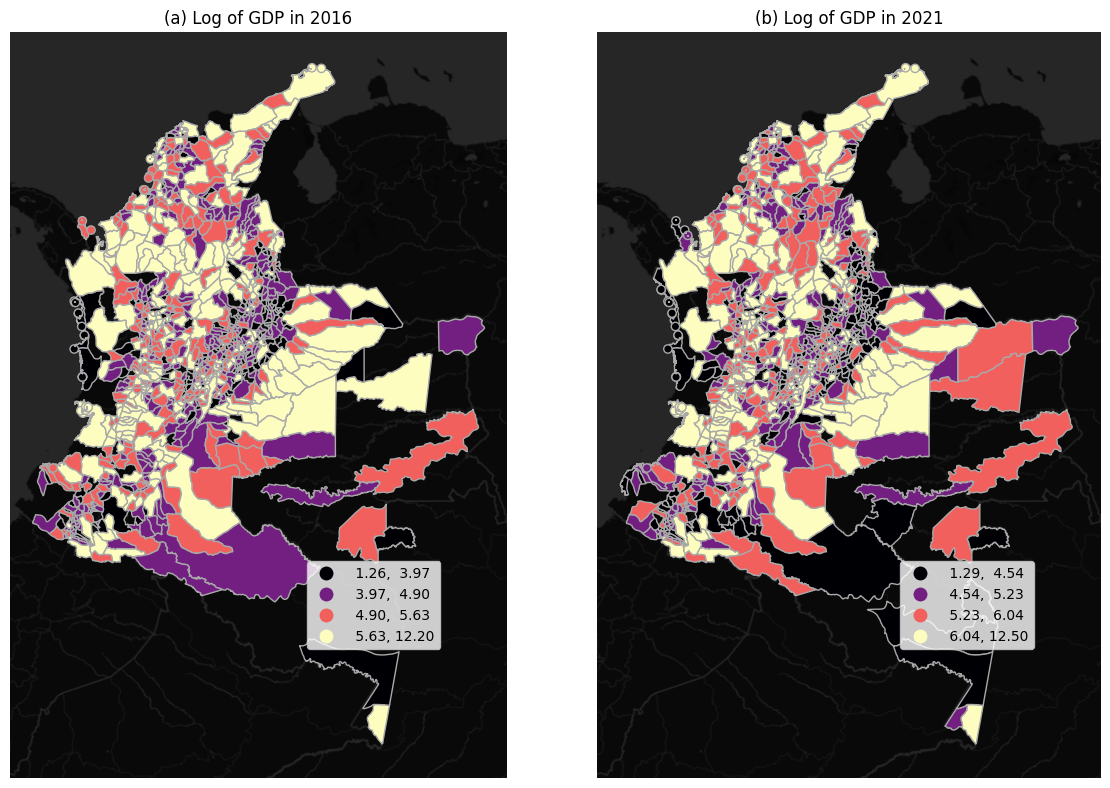

In [ ]:
# @title Plot static map of (log) GPTpc for the initial and final year

# A figure is initialized
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

# The plot of the start year is added
gdf_pivoted_lnGDP.plot(
    column=str(START_YEAR),
    scheme="user_defined",
    classification_kwds={"bins": [3.97, 4.90, 5.63]},
    k=4,
    cmap="magma",
    edgecolor="darkgrey",
    legend=True,
    ax=axes[0],
    legend_kwds={"bbox_to_anchor": (0.88, 0.30)},
)
cx.add_basemap(
    ax=axes[0],
    crs=gdf_pivoted_lnGDP.crs.to_string(),
    source=cx.providers.CartoDB.DarkMatterNoLabels,
    attribution=False,
)


# The plot of the end year is added.
gdf_pivoted_lnGDP.plot(
    column=str(END_YEAR),
    scheme="Quantiles",
    k=4,
    cmap="magma",
    edgecolor="darkgrey",
    legend=True,
    ax=axes[1],
    legend_kwds={"bbox_to_anchor": (0.88, 0.30)},
)
cx.add_basemap(
    ax=axes[1],
    crs=gdf_pivoted_lnGDP.crs.to_string(),
    source=cx.providers.CartoDB.DarkMatterNoLabels,
    attribution=False,
)

plt.tight_layout()
axes[0].axis("off")
axes[1].axis("off")
axes[0].set_title("(a) Log of GDP in " + str(START_YEAR))
axes[1].set_title("(b) Log of GDP in " + str(END_YEAR))

plt.savefig("lnGDP.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Exploring the relationship between NTL and PIB

In [ ]:
fig_sc_ln_meanNTL_lnGDP = px.scatter(
    data_frame= gdf_merged,
    x="ln_sumNTL",
    y="lnGDP",
    range_x=[0, 20],
    range_y=[0, 15],
    hover_name="ADM2_NAME",
    animation_frame="year",
)

fig_sc_ln_meanNTL_lnGDP.show()

In [ ]:
gdf_merged["ADM1_NAME"] = gdf_merged["ADM1_NAME"].astype(str)
gdf_merged["ADM2_NAME"] = gdf_merged["ADM2_NAME"].astype(str)
gdf_merged["year"] = gdf_merged["year"].astype(int)

In [ ]:
df_merged = gdf_merged.drop(columns="geometry")

In [ ]:
df_merged.head()

,ADM1_NAME,ADM2_NAME,sumNTL,ln_sumNTL,year,GDP,lnGDP
0,Amazonas,Leticia,407.028357,12.916663,2016,469.186170,6.151021
1,Amazonas,Tarapaca,0.143182,5.031627,2016,15.168626,2.719888
2,Antioquia,Abejorral,192.184141,12.166261,2016,202.311691,5.309859
3,Antioquia,Abriaqui,12.914525,9.466882,2016,20.171697,3.004776
4,Antioquia,Alejandria,35.364022,10.473733,2016,46.560466,3.840967


In [ ]:
df_merged = df_merged.set_index(["ADM2_NAME", "year"]).sort_index()

In [ ]:
# @title Conduct panel data regressions

table = {
    "(1) Pooled": PooledOLS.from_formula(
        formula="lnGDP ~ 1 + ln_sumNTL", data=df_merged
    ).fit(cov_type="clustered"),
    "(2) Between": BetweenOLS.from_formula(
        formula="lnGDP ~ 1 + ln_sumNTL", data=df_merged
    ).fit(cov_type="clustered"),
    "(3) Within": PanelOLS.from_formula(
        formula="lnGDP ~ 1 + ln_sumNTL + EntityEffects + TimeEffects", data=df_merged
    ).fit(cov_type="clustered"),
}

In [ ]:
# @title Show comparative regression table

summary = compare(table,
stars = True
)
print(summary)

                          Model Comparison                         
                            (1) Pooled    (2) Between    (3) Within
-------------------------------------------------------------------
Dep. Variable                    lnGDP          lnGDP         lnGDP
Estimator                    PooledOLS     BetweenOLS      PanelOLS
No. Observations                  5812            911          5812
Cov. Est.                    Clustered      Clustered     Clustered
R-squared                       0.5859         0.6198        0.2289
R-Squared (Within)              0.0453         0.0208        0.2348
R-Squared (Between)             0.6192         0.6198        0.4565
R-Squared (Overall)             0.5859         0.5854        0.4401
F-statistic                     8221.7         1481.8        1452.9
P-value (F-stat)                0.0000         0.0000        0.0000
=====================     ============   ============   ===========
Intercept                   -0.9422***     -1.11

In [ ]:
# @title CODE: Introducing a cuadratic term
df_merged["ln_sumNTL_2"] = df_merged["ln_sumNTL"] ** 2

In [ ]:
table1 = {
    "(1) Pooled": PooledOLS.from_formula(
        formula="lnGDP ~ 1 + ln_sumNTL + ln_sumNTL_2", data=df_merged
    ).fit(cov_type="clustered"),
    "(2) Between": BetweenOLS.from_formula(
        formula="lnGDP ~ 1 + ln_sumNTL + ln_sumNTL_2", data=df_merged
    ).fit(cov_type="clustered"),
    "(3) Within": PanelOLS.from_formula(
        formula="lnGDP ~ 1 + ln_sumNTL + ln_sumNTL_2 + EntityEffects + TimeEffects", data=df_merged
    ).fit(cov_type="clustered"),
}

In [ ]:
# @title Show comparative regression table

summary = compare(table1,
stars = True
)
print(summary)

                          Model Comparison                          
                            (1) Pooled    (2) Between     (3) Within
--------------------------------------------------------------------
Dep. Variable                    lnGDP          lnGDP          lnGDP
Estimator                    PooledOLS     BetweenOLS       PanelOLS
No. Observations                  5812            911           5812
Cov. Est.                    Clustered      Clustered      Clustered
R-squared                       0.6788         0.7092         0.3485
R-Squared (Within)              0.2957         0.2853         0.3450
R-Squared (Between)             0.7088         0.7092         0.6385
R-Squared (Overall)             0.6788         0.6784         0.6183
F-statistic                     6138.6         1107.4         1309.1
P-value (F-stat)                0.0000         0.0000         0.0000
=====================     ============   ============   ============
Intercept                    7.473